In [1]:
from dataset import load_diabetes
X, y = load_diabetes()
print(X.shape)
print(y.shape)

(442, 10)
(442,)


In [2]:
# split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# scale y
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [3]:
from src.Mondrian_forest import evaluate_all_lifetimes

In [4]:
M = 10                      # number of Mondrian trees to use
delta = 0 
lifetime_max = 10

In [5]:
results = []
results.append(
    evaluate_all_lifetimes(X_train, 
                           y_train, 
                           X_test, y_test, M, lifetime_max, delta))

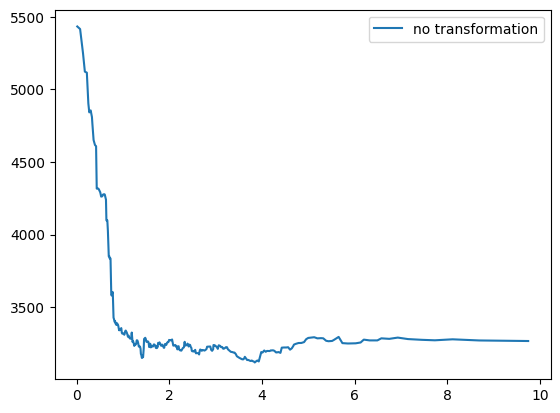

In [6]:
import matplotlib.pyplot as plt
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.legend()

In [7]:
from src.Mondrian_forest import train
from src.estimate_H import estimate_H_finite_diff
from src.Mondrian_forest import transform_data, two_one_norm
history, w_trees = train(
            X_train, y_train, M, lifetime_max, delta
        )
H_1 = estimate_H_finite_diff(X_train, y_train, M, history, w_trees, step=0.1)
X_train_transformed, X_test_transformed = transform_data(H_1/two_one_norm(H_1), X_train, X_test)

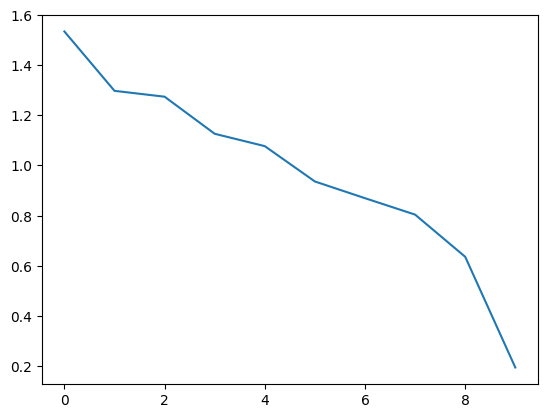

In [8]:
import numpy as np
eigvals = np.linalg.eig(H_1/two_one_norm(H_1))[0]
# sort eigenvalues
eigvals = np.sort(eigvals)[::-1]
# plot eigenvalues
plt.plot(eigvals)

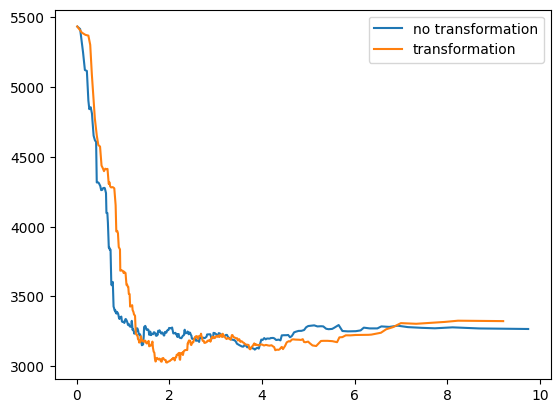

In [9]:
results.append(
    evaluate_all_lifetimes(X_train_transformed, 
                           y_train, 
                           X_test_transformed, y_test, M, lifetime_max, delta))
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transformation')
plt.legend()

In [10]:
import numpy as np
history, w_trees = train(
            X_train_transformed, y_train, M, lifetime_max, delta
        )
H_2 = estimate_H_finite_diff(X_train_transformed, y_train, M, history, w_trees, step=0.1)
X_train_transformed, X_test_transformed = transform_data(H_2 * two_one_norm(H_1) / two_one_norm(np.matmul(H_2, H_1)), X_train_transformed, X_test_transformed)


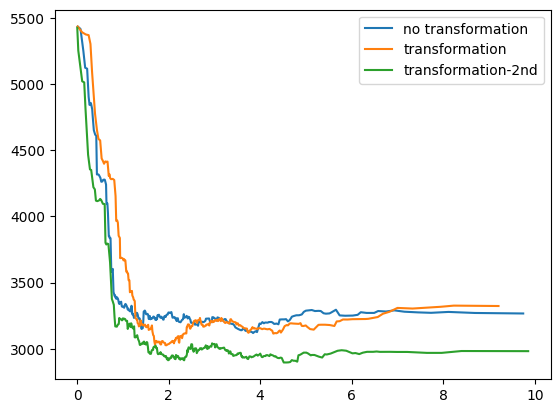

In [11]:
results.append(
    evaluate_all_lifetimes(X_train_transformed, 
                           y_train, 
                           X_test_transformed, y_test, M, lifetime_max, delta))
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transformation')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transformation-2nd')
plt.legend()

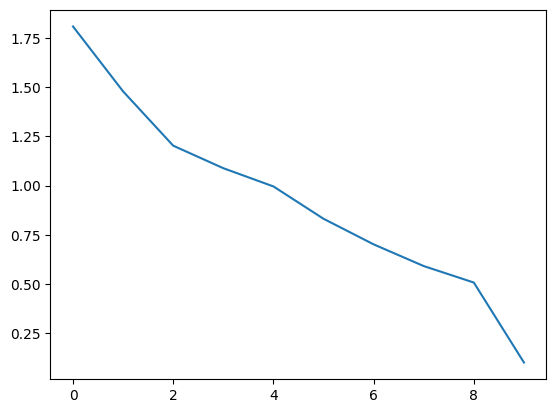

In [12]:
eigvals = np.linalg.eig(np.matmul(H_2, H_1)/two_one_norm(np.matmul(H_2, H_1)))[0]
# sort eigenvalues
eigvals = np.sort(eigvals)[::-1]
# plot eigenvalues
plt.plot(eigvals)

In [13]:
# fit random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor(n_estimators=10, random_state=42, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)

/Users/yangxinyuxie/Desktop/Mondrian Forests/vie/.venv/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


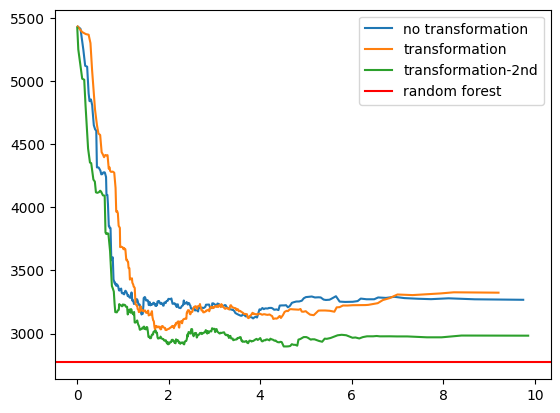

In [14]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transformation')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transformation-2nd')
# add a horizontal line for the random forest
plt.axhline(y=rf_mse, color='r', linestyle='-', label = 'random forest')
plt.legend()

In [19]:
H_3 = np.matmul(H_2, H_1)/two_one_norm(np.matmul(H_2, H_1))
# only show first 1 digits
np.set_printoptions(precision=1)
H_3

array([[ 0.1, -0.1, -0.1, -0.1, -0. , -0.1,  0.1, -0.1, -0.2, -0.1],
       [-0.1,  1.2,  0.2,  0.1, -0.1,  0. ,  0.1,  0.2,  0.2, -0. ],
       [-0. ,  0.2,  0.9,  0.2, -0.1,  0.1, -0.2,  0.1,  0.3,  0.2],
       [-0. ,  0.1,  0.2,  1. , -0.1, -0. ,  0. , -0. ,  0.3,  0. ],
       [-0. , -0.1, -0.1, -0.1,  1. ,  0.1,  0.1,  0. ,  0. ,  0.1],
       [-0. ,  0. ,  0.1, -0. ,  0.1,  0.9,  0.1, -0.1, -0. ,  0.1],
       [ 0. ,  0.1, -0.1,  0. ,  0.1,  0.2,  1.3, -0.1,  0. , -0.1],
       [-0.1,  0.2,  0. , -0. ,  0.1, -0.1, -0.1,  0.7,  0. ,  0. ],
       [-0.1,  0.2,  0.3,  0.4,  0. , -0.1, -0. ,  0.1,  1.1,  0. ],
       [-0. , -0. ,  0.1,  0. ,  0.1,  0.1, -0.1,  0. , -0. ,  1. ]])